In [1]:
import json
import numpy as np
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
import utils.bit_tools as bit
import utils.cs_vqe_tools_original as cs_tools
from qat.lang.AQASM import Program, X, H, S, CNOT, RZ
from qat.core.variables import Variable
from qat.core import Observable, Term
from matplotlib import pyplot as plt

Package not installed


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'H3+_STO-3G_SINGLET_alt', 'HeH+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET_alt', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET_alt', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'N+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'F+_STO-3G_SINGLET', 'Li+_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET'])

In [3]:
speciesname = "B+_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']
#num_tapered = molecule['num_tapered']

B+_STO-3G_SINGLET reaches chemical accuracy for 3-qubit CS-VQE


/usr/local/lib64/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1269: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


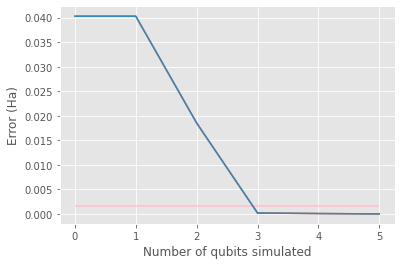

In [4]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

Exact ground state energy:  -24.189264917100267
[(1.0, '11111'), (0.0, '00000'), (0.0, '00001'), (0.0, '00010'), (0.0, '00011')]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


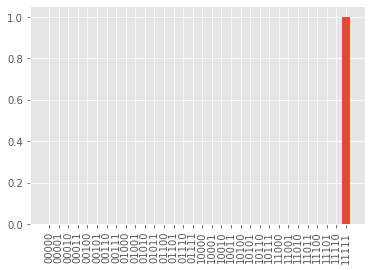

In [5]:
import numpy as np
from qat.dqs.hamiltonians import SpinHamiltonian

ham_rot = cs_tools.rotate_operator(mol_circ.ham_rotations, ham)
full_terms = [Term(coeff, op, list(range(num_qubits))) for op, coeff in ham.items()]
ham_spin = SpinHamiltonian(nqbits=num_qubits, pauli_terms=full_terms)
ham_matrix = ham_spin.get_matrix()
eigvals, eigvecs = np.linalg.eigh(ham_matrix)
gs = sorted(list(zip(eigvals, eigvecs)), key=lambda x:x[0])[0]

print("Exact ground state energy: ", gs[0])
basis_states = [bit.int_to_bin(i, num_qubits) for i in range(2**num_qubits)]
sig_states = sorted(list(zip(abs(gs[1])**2, basis_states)), key=lambda x:-x[0])
print(sig_states[:5])

fig, ax = plt.subplots()
l1=ax.bar(basis_states, [abs(a)**2 for a in gs[1]])
l2=ax.set_xticklabels(basis_states, rotation=90)

In [6]:
nonconstate = mol_circ.reference_state()
reverse_rot = []
for angle, rot in mol_circ.ham_rotations[::-1]:
    if angle == 'pi/2':
        reverse_rot.append([-np.pi/2, rot])
    else:
        reverse_rot.append([-angle, rot])

anz={}
for amp, state in sig_states[:2]:
    differs=[index for index, b in enumerate(state) if nonconstate[index]!=b]
    #pot_ops=[]
    #for op in uccsd.keys():
    #    diff_bits = {op[i] for i in differs}
    #    same_bits = {op[i] for i in range(num_qubits) if i not in differs}
    #    if diff_bits in [{'X'}, {'Y'}, {'X', 'Y'}] and same_bits in [{'I'},{'Z'},{'I', 'Z'}]:
    #        pot_ops.append(op)
    blank_op = ['I' for i in range(num_qubits)]
    for i in differs:
        blank_op[i] = 'X'
    op = ''.join(blank_op)
    if set(op)!={'I'}:
        anz[op] = amp

out_anz = cs_tools.rotate_operator(reverse_rot, anz)
out_anz

{'XXXII': 9.242537443310976e-89,
 'XXYZX': -8.192848691747605e-82,
 'YYYIY': 2.641133142686878e-82,
 'ZXXII': -1.436617050493236e-72,
 'IYXZZ': -4.631230293839831e-73,
 'ZXYZX': 1.405799628556206e-65,
 'ZYYZI': 1.436617050493236e-72,
 'IXYIZ': -4.631230293839831e-73,
 'ZYXIX': 1.405799628556206e-65,
 'XYYZI': 2.465071420146179e-56,
 'XYXIX': 2.185109585271443e-49,
 'YXXZY': 7.0441497984410455e-50,
 'XZXII': -2.3461736910486595e-56,
 'YIXZZ': -7.56337304284676e-57,
 'XZYZX': 2.2958450216584542e-49,
 'ZZXII': 4.025767138512847e-40,
 'ZZYZX': -3.5685547650029405e-33,
 'IIYIY': -1.1503969639810363e-33,
 'XXZII': -1.405799628556214e-65,
 'ZXZII': 2.185109585271456e-49,
 'IYZZZ': 7.044149798441086e-50,
 'XZZII': 1.3379937296944444e-65,
 'YIZZZ': 4.313297751687675e-66,
 'ZZZII': -2.2958450216584675e-49,
 'ZIIZI': -2.2958450216584675e-49,
 'XIIZI': -3.568554765002961e-33,
 'YZIIZ': -1.150396963981043e-33,
 'XZIZI': 1.3379937296944444e-65,
 'YIIIZ': 4.313297751687675e-66,
 'ZZIZI': -2.295845021

In [7]:
import random
#anz_ops = ['XIZXX', 'IYZXX'] #for B+ 
#anz_ops = ['YXIIXXII', 'IXIIZZZY', 'XYIIZZXX', 'YYIIXYII'] #for HF
#anz_ops = ['IIYXX', 'ZYIYX', 'YZZXY', 'IYIZI', 'ZZYYY']#random.choices(list(uccsd.keys()), k=5)
#print(anz_ops)
#anz = {op:uccsd[op] for op in anz_ops}
anz=uccsd
ham_dict, num_sim_q, num_params, instructions = mol_circ.qlm_circuit(anz, num_sim_q).values()

In [8]:
pauli_terms = [Term(coeff, op, list(range(num_sim_q))) for op, coeff in ham_dict.items()]
hamiltonian = Observable(num_sim_q,
               pauli_terms=pauli_terms)
print("Hamiltonian:", hamiltonian)

Hamiltonian: -22.759376450401625 * I^3 +
-0.6311272727525714 * (Z|[0]) +
-0.6311272727525677 * (ZZ|[0, 1]) +
0.5076986662124542 * (Z|[1]) +
0.4771381984710478 * (ZZZ|[0, 1, 2]) +
0.47713819847104905 * (ZZ|[0, 2]) +
-0.31922012815549117 * (Z|[2]) +
0.015814815627810057 * (XZ|[0, 1]) +
-0.015814815627810057 * (X|[0]) +
-0.021704251968601714 * (YXY|[0, 1, 2]) +
-0.052041087385551514 * (YYY|[0, 1, 2]) +
-0.052041087385551514 * (XYX|[0, 1, 2]) +
-0.021704251968601714 * (XXX|[0, 1, 2]) +
0.021704251968601714 * (ZYY|[0, 1, 2]) +
-0.052041087385551514 * (ZXY|[0, 1, 2]) +
0.021704251968601714 * (XX|[1, 2]) +
0.052041087385551514 * (YX|[1, 2])


In [9]:
gate_dict = {'X':X,'H':H,'S':S,'SDG':S.dag(),'RZ':RZ,'CX':CNOT}
prog = Program()
qbits_reg = prog.qalloc(num_sim_q)
params = [prog.new_var(float, "\\P{}".format(i)) for i in range(num_params)]

for gate, var_num, q_pos in instructions:
    q_pos = [num_sim_q-p-1 for p in q_pos] #qubit ordering is reversed compared with Qiskit
    if gate == 'RZ':
        prog.apply(RZ(params[var_num[0]]), qbits_reg[q_pos[0]])
    elif gate == 'CX':
        prog.apply(CNOT, qbits_reg[q_pos[0]], qbits_reg[q_pos[1]])
    else:
        prog.apply(gate_dict[gate], qbits_reg[q_pos[0]])

qc = prog.to_circ()

In [10]:
from qat.plugins import ScipyMinimizePlugin
from qat.qpus import Stabs, LinAlg, MPS, Feynman
#from qat.plugins import SPSAMinimizePlugin
#from qat.plugins import PSOMinimizePlugin

theta0 = mol_circ.init_param
linalg_qpu = LinAlg(use_GPU=False)

#optimizer_pso = PSOMinimizePlugin(theta0, max_iter=50, swarm_number=10)
#optimizer_spsa = SPSAMinimizePlugin(theta0)
optimizer_scipy = ScipyMinimizePlugin(method="Nelder-Mead",
                                      tol=1e-3,
                                      options={"maxiter": 3000})

qpu = optimizer_scipy | linalg_qpu

job = qc.to_job(job_type="OBS", observable=hamiltonian)

result = qpu.submit(job)

print("Minimum energy =", result.value)
print("Optimal angles =", result.meta_data["parameters"])

Minimum energy = -24.189062662993997
Optimal angles = [0.8741594815832474, 0.04942889370896615, 0.28199661096676887, 0.9187258142668033, -0.2530022460543896, -0.24306661516304243, 0.13516086284343737, 0.016207531239776703, -0.09508815485175692, -0.277236245420194, 0.5276448786289901, 0.064221395592067, 0.11221863272133144, 0.15467041599424497, 0.23877357791827902, 0.12918760100414023, 0.9181705558909798, 0.10502796174224606, 2.2081418536620774, -0.2433366849126981]


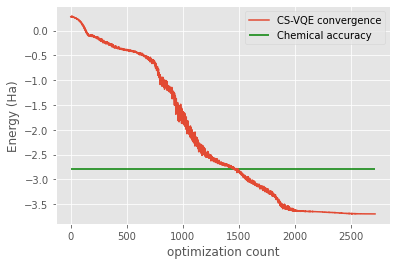

In [11]:
nfev = len(eval(result.meta_data['optimization_trace']))
energy=eval(result.meta_data['optimization_trace'])
plt.plot([np.log10(abs(x-mol_circ.truegs)) for x in energy], label='CS-VQE convergence')
plt.hlines(np.log10(0.0016), 0, nfev, color='green', label='Chemical accuracy')
#plt.hlines(true_gs+0.0016, 0, nfev, color='pink')
plt.xlabel("optimization count")
plt.ylabel("Energy (Ha)")
plt.legend()